**Last Update:** 2022/12/26

In [3]:
import warnings
warnings.simplefilter('ignore')

# Data Processing 
import numpy as np
import pandas as pd
import time
from datetime import datetime, date, time, timedelta
from scipy import stats

# Visualization
import seaborn as sns
import matplotlib as mlb
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # for x-axis scale shrinkage
%matplotlib inline
sns.set(style="white",context="talk")
from matplotlib.ticker import PercentFormatter # For percentage histogram

# Plotly
import plotly.express as px
# Plotly Color Scale RGB Reference: https://plotly.com/python/discrete-color/
# Use this: px.colors.qualitative.Set2
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.io as pio
from plotly.subplots import make_subplots
pio.templates.default = "none"

# Model
from sklearn.metrics import auc, roc_curve, classification_report



In [2]:
from platform import python_version
print('Seaborn version: ',sns.__version__)
print('Matplotlib version: ',mlb.__version__)
print('Python version: ',python_version())

Seaborn version:  0.11.2
Matplotlib version:  3.5.1
Python version:  3.9.12


**Load the data for illustration**

In [405]:
df = sns.load_dataset("tips")

In [406]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


# Data Preview and Processing

**agg() transform 1 column for multiple metrics**       
`df.groupby(..).agg({...:['sum','mean',...]})`     
`df.groupby(by='cluster').agg(
    age_mean=pd.NamedAgg(column='age', aggfunc='mean'),
    age_std=pd.NamedAgg(column='age', aggfunc='std'),
    creditamount=pd.NamedAgg(column='creditamount', aggfunc='mean')
).sort_values(by='class_mean')`

In [381]:
df = sns.load_dataset('dowjones')
df['7d_price_mean'] = df.Price.rolling(7).mean()

In [393]:
def get_return(series):
    return (series[6]-series[0])/series[0]

In [398]:
df = sns.load_dataset('dowjones')
df['7d_price_return'] = df.Price.rolling(7).apply(lambda x:sum([i**2 for i in x]))


## Data Loading

### Read in Large File 

In [ ]:
def read_csv_chunk(filepath,chunksize):
    num_of_chunk = 0

    df = pd.DataFrame()

    for chunk in pd.read_csv(filepath, sep=',',
                             chunksize=chunksize):
        num_of_chunk += 1
        df = pd.concat([df, chunk], axis=0)
        print('Processing Chunk No. ' + str(num_of_chunk))     

    print("The dataset's shape: ", df.shape)
    df.reset_index(inplace=True)
    return df

In [ ]:
def read_zip_csv_chunk(filepath, filename, chunksize):
    num_of_chunk = 0

    df = pd.DataFrame()
    zf = zipfile.ZipFile(filepath) 

    for chunk in pd.read_csv(zf.open('tweets.csv'), 
                             delimiter=';', skiprows=0, lineterminator='\n',
                             chunksize=chunksize):
        num_of_chunk += 1
        df = pd.concat([df, chunk], axis=0)
        print('Processing Chunk No. ' + str(num_of_chunk))     

    print("The dataset's shape: ", df.shape)
    df.reset_index(inplace=True)
    return df

## Data Viewing

### Data Preivew

In [5]:
def view(df):
    # Exploring the data types, number of unique values and missing values
    # Reference: Github @mintao_w
    cols = df.columns
    print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"The columns are: {cols.tolist()}")
    return pd.concat(
        [
            pd.DataFrame({
            "data_types":df.dtypes, 
            "value_counts": df.nunique(),
            "null_counts": df.isnull().sum(),
            "mean_values": [round(df[col].mean(),2) if df[col].dtype.name != 'category' else 'N/A' for col in cols],
            "max_values": [df[col].max() if df[col].dtype.name != 'category' else 'N/A' for col in cols]                
            }).T,
            df.iloc[0:3,:]
        ],
        axis = 0)

In [6]:
view(df)

The dataset consists of 244 rows and 7 columns
The columns are: ['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size']


,total_bill,tip,sex,smoker,day,time,size
data_types,float64,float64,category,category,category,category,int64
value_counts,229,123,2,2,4,2,6
null_counts,0,0,0,0,0,0,0
mean_values,19.79,3.0,N/A,N/A,N/A,N/A,2.57
max_values,50.81,10.0,N/A,N/A,N/A,N/A,6
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.5,Male,No,Sun,Dinner,3


### Value Count Distribution

In [252]:
def unique_val_dist(data,feature):
    # Reference: Github @mintao_w
    total = data.loc[:,feature].value_counts(dropna=False)
    percentage = round(data.loc[:,feature].value_counts(dropna=False, normalize=True),2)
    
    return pd.concat([total,percentage],axis=1,keys=['# Occurrences','Percentage'])


# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("tips")
unique_val_dist(df,'day')

,# Occurrences,Percentage
Sat,87,0.36
Sun,76,0.31
Thur,62,0.25
Fri,19,0.08


## Data Preprocessing

### Date Transformation
> Should be really careful when the original ts_col is called "date" (overlapping with the date column we are about to generate)

In [377]:
df = sns.load_dataset('dowjones')
df.dtypes

Date      object
Price    float64
dtype: object

In [249]:
# From string datetime "2022-10-27" to datetime64[ns] format
# Method 1: astype
df['Date2'] = df['Date'].astype('datetime64')
# Method 2: strptime
df['Date2'] = list(map(lambda x: datetime.strptime(x,"%Y-%m-%d"), df['Date']))
# Method 3: fromisoformat => Return a date corresponding to a date_string given in any valid ISO 8601 format
df['Date2'] = list(map(lambda x: datetime.fromisoformat(x), df['Date']))
# Method 4: pd.to_datetime
df['Date2'] = pd.to_datetime(df['Date'])

# From datetime64[ns] format to string format
# Method 1: astype
df['Date3'] = df['Date2'].astype('object')
# Method 2: strftime
df['Date3'] = list(map(lambda x: datetime.strftime(x,"%Y-%m-%d"), df['Date2']))

df.dtypes

Date             object
Price           float64
Date2    datetime64[ns]
Date3            object
dtype: object

In [ ]:
# Time Delta
# Using current time
ini_time_for_now = datetime.now()
 
# printing initial_date
print ("initial_date", str(ini_time_for_now))
 
# Calculating future dates
# for two years
future_date_after_2yrs = ini_time_for_now + \
                        timedelta(days = 730)
 
future_date_after_2days = ini_time_for_now + \
                         timedelta(days = 2)

In [9]:
def add_date_factors(df, ts_col, is_datetime):
    '''
    Assumption: the currect ts_col is a timestamp datatype
    
    Input:
    df (dataframe, target dataframe to be transformed)
    ts_col(string, name of the timestamp column)
    is_datetime(boolean, whether ts_col is datetime object or not)
    
    Output:
    This function generates hour, hour_of_day, date, weekday, week_of_month, months, year
    '''
    if is_datetime:
        pass
    else:
        df[ts_col] = list(map(lambda x: datetime.fromisoformat(x),df[ts_col].replace(":60",":59", regex=True)))

    # Hour
    df["hour"] = list(map(lambda x: x.hour, df[ts_col]))    

    # Hour of day
    def get_hourday(x):
        if 0<= x < 6:
            return "midnight"
        elif 6<= x < 12:
            return "morning"
        elif 12<= x < 18:
            return "afternoon"
        else:
            return "night"
    df["hourday"] = list(map(lambda x: get_hourday(x), df["hour"]))
        
    # Date
    df["date"] =  list(map(lambda day:day.date(), df[ts_col]))

    # Weekday
    wkday_dict = {1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat",7:"Sun"}
    df["weekday_index"] = list(map(lambda x: x.date().weekday()+1, df[ts_col]))
    df['weekday'] = list(map(lambda x: wkday_dict[x],df["weekday_index"]))

    # Week_of_month (assuming 4 weeks in a month)
    def get_week(day):
        if 1<= day.day < 8:
            return ("first_week",1)
        elif 8<= day.day < 15:
            return ("second_week",2)
        elif 15<= day.day < 22:
            return ("third_week",3)
        else:
            return ("last_week",4)
    df["week"] = list(map(lambda day: get_week(day)[0], df[ts_col]))
    df["week_index"] = list(map(lambda day: get_week(day)[1], df[ts_col]))

    # Month
    month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
    df["month_index"] = list(map(lambda day: day.month, df[ts_col]))
    df["month"] = list(map(lambda m: month_dict[m], df["month_index"]))

    # Year
    df["year"] = list(map(lambda x:x.year,df[ts_col]))
    return df

### Reduce Memory Usage

In [10]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            try:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            except:
                pass
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Textual Preprocessing

In [ ]:
# Text processing
import re 
from textblob import TextBlob
import string

# Word cloud visualization
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# Machine learning (sentiment analysis)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

# This one will be used to help us with lexicon
import nltk

# Other visualization
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def light_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Remove Links
    text = re.sub(r'http\S+', '', text)                                

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def heavy_preprocessing_for_sentiment(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s



def heavy_preprocessing_for_topic(s,lemmatizer=lemmatizer):
    """
    This heavy preprocessing function serves the specific purpose for topic modeling, rather than sentiment analysis
    """
    s = s.lower()
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove hashtags
    s = re.sub("#\S+", " ", s)
    # Remove ticks and the next character
    s = re.sub("\'\w+", '', s)        
    # Isolate and remove punctuations (synonymous to string.punctuation)
    s = re.sub(r'[^\w\s]|\_', ' ', s) 
    # Remove numbers
    s = re.sub(r'\w*\d+\w*', '', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopword or non-English word
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english') and word.encode().isalpha()])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    # Lemmatization
    s = ' '.join([lemmatizer.lemmatize(word) for word in s.split()])
    return s

In [ ]:

#Removing Punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0–9]+', '', text)
    return text
# twitter_data['punct'] = twitter_data['text'].apply(lambda x: remove_punct(x))

#Applying tokenization- splitting a phrase, sentence, paragraph, or an entire text document into smaller units
def tokenization(text):
    text = re.split('\W+', text)
    return text
# twitter_data['tokenized'] = twitter_data['punct'].apply(lambda x: tokenization(x.lower()))


#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
# twitter_data['nonstop'] = twitter_data['tokenized'].apply(lambda x: remove_stopwords(x))

#Applying Stemmer
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text
# twitter_data['stemmed'] = twitter_data['nonstop'].apply(lambda x: stemming(x))

#Cleaning Text
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text


### Sentiment Labels
**Lexicon-based Approach to Extract Sentiments: VADER**   
*VADER doesn't require pre-processing work, it handles emojis, slangs, emoticons pretty well*
> The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).             
- positive sentiment : (compound score >= 0.05) 
- neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
- negative sentiment : (compound score <= -0.05)        
Source: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f; https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 
# function to print sentiments
# of the sentence.
def get_vader_sentiment(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    sentiment_score = sentiment_dict['compound']

    # print("Overall sentiment dictionary is : ", sentiment_dict)
    # print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    # print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    # print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
    # print("Sentence Overall Rated As", end = " ")

    # sentimen classification
    if sentiment_dict['compound'] >= 0.05 :
        sentiment_type = 'positive'
    elif sentiment_dict['compound'] <= - 0.05 :
        sentiment_type = 'negative'
    else :
        sentiment_type = 'neutral'
    return sentiment_type, sentiment_score

# EDA

## Visualization

**Very useful & handy code to deal with x-ticks**    
Enable the x-axis to display 5 times fewer ticks (only 1/5)(change parameters)       
`ax.xaxis.set_major_locator(ticker.MultipleLocator(5))`    
Rotate the x-ticks while also keep the shrinked version of x-ticks     
`plt.setp(ax.get_xticklabels(), fontsize = 12, rotation=45, ha="right", rotation_mode="anchor")`

**Save the Picture**     
Higher dpi and .png give us high resolution pictures      
`plt.savefig(path,
    dpi=300,
    bbox_inches='tight' # sometimes default savefig method cuts off the x-axis and x-ticks. This param avoids that 
)` 


**Auxiliary Line (x-axis & y-axis)**     
`ax[...].axhline(y=...,ls="--",c="yellowgreen",alpha = 0.7)`        
`ax[...].axvline(x=...,ls="--",c="yellowgreen",alpha = 0.7)`

**Auxiliary Shaded Area (x-axis & y-axis)**         
`ax.axvspan(x1=..., x2=..., alpha=0.2)`

### Comprehensive Summary

In [11]:
def subplot_loop(df, nrows, ncols, columns, figsize=(20,12)):
    '''
    This subplot_loop functions enable matrix-wise subplots.
    
    Input:
        df: dataframe 
        nrows: number of rows of the subplot
        ncols: number of columns of the subplot
        columns: a list of columns that will be visualized in the subplots in order
        figsize: a tuple of figure size
    Output:
        None
        
    '''
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        # Key highlights! => axes.flatten creates a iterable sequence
        data = df[columns[i]]        
        ax.plot(data, color= 'royalblue', linewidth=1)
        ax.set_title(dataset.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout()

In [ ]:
def eda_plot(df,col_x,col_y, plot_type,col_dt="",figsize_x=14, figsize_y=6):
    '''
    This helper function integrates boxplot, barchart, distribution-plot all together. 
    The plot_type parameter controls the output graph format.
    
    Input:
        df: PANDAS DATAFRAME
        col_dt: STRING, the column name of the date variable
        col_x: STRING, the column name of the key independent variable 
        col_y: STRING, the column name of the key dependent variable
        plot_type: STRING, including boxplot, categorical plot, histogram plot for continuous variables
        figsize_x: INT, control the length of the figure canvas
        figsize_y: INT, control the width of the figure canvas
    Output:
        None
    '''
    if plot_type == 'boxplot':
        # Test outliers by checking the distribution of active_mins
        f = plt.figure(figsize = (figsize_x,figsize_y))
        sns.boxplot(data = df[col_x], color = "yellowgreen")

        plt.title(f"{col_x} Distribution: No Apparently Erroneous Reported Age")
        plt.ylabel(col_x)
        plt.xlabel(col_x)
        plt.xticks([]) # remove the labels on the x-axis
        plt.show()        
    elif plot_type == 'catplot':
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figsize_x,figsize_y))
        sns.countplot(x=col_x, 
                      data=df.sort_values(by = col_x),ax=axes[0],palette=sns.color_palette("viridis",df[col_x].nunique()))
        axes[0].set_title(f'Count Plot of {col_x}', fontsize=14)
        axes[0].grid(linestyle="--", alpha=0.2)

        sns.barplot(x=col_x, y=col_y, 
                    data=df.sort_values(by = col_x), ci=0, ax=axes[1],palette=sns.color_palette("viridis",df[col_x].nunique()));
        axes[1].set_title(f'Mean Conversion Rate by {col_x}', fontsize=14)
        axes[1].grid(linestyle="--", alpha=0.2)

        fig.suptitle("XX", fontsize = 16)
        plt.show()
    elif plot_type == 'histplot':
        sns.set(style="white",context="talk")
        grouped = df.groupby(col_x)[col_y].mean().reset_index()
        hist_kws={'histtype': 'bar', 'alpha': 0.2}

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(figsize_x,figsize_y))
        sns.distplot(df[df[col_y] == 0][col_x],
                     label='XXX', ax=axes[0], hist_kws=hist_kws)
        sns.distplot(df[df[col_y] == 1][col_x], 
                     label='XXX', ax=axes[0], hist_kws=hist_kws)
        axes[0].set_title(F'Density of {col_x}', fontsize=16)
        axes[0].set_xlabel(col_x,fontsize = 16)
        axes[0].legend()
        axes[0].grid(linestyle="--", alpha=0.3)

        axes[1].plot(grouped[col_x], grouped[col_y])
        axes[1].set_title(f'Mean Conversion across {col_y}', fontsize=16)
        axes[1].set_xlabel(col_x,fontsize = 16)
        axes[1].set_ylabel('Mean Conversion',fontsize = 16)
        axes[1].grid(linestyle="--", alpha=0.3)

        fig.suptitle("XXXXX", fontsize = 18)
        plt.show()   
    elif plot_type == 'lineplot':
        grouped = df.groupby([col_dt,col_x])[col_y].mean().reset_index()

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
        sns.lineplot(x=col_dt, y=col_y,hue = col_x,
                     # marker = 'o', markersize = 7,
                     data=grouped,ax=ax,
                    palette =sns.color_palette("viridis",df[col_x].nunique()))
        ax.set_title(f"Average {col_y} XXX")
        ax.set_ylabel(f"{col_y}")
        plt.show()
    elif plot_type == 'scatterplot':
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(figsize_x,figsize_y))
        sns.scatterplot(
            x=col_x, y=col_y,# hue = ?,
            data=df,ax=ax,
            size=10, 
            linewidth= 0, # get ride of the surrounding frame
            alpha=0.7, # make it transparent so I could visualize how much they overlap
            color = 'seagreen',
            palette =sns.color_palette("viridis"))
        ax.set_title(f"Average {col_y} XXX")
        ax.set_ylabel(f"{col_y}")
        ax.grid(linestyle="--", alpha=0.5)
        plt.show()        

### Uni-Variate

#### Histogram Plot

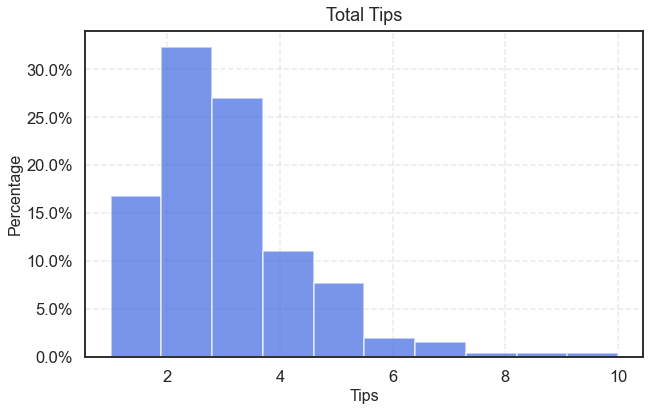

In [411]:
from matplotlib.ticker import PercentFormatter
# # Old version: Not used
# def helper_hist_plot(df, col_x, title='ENTER-TITLE-HERE', xlabel = 'ENTER-XLABEL-HERE', ylabel = 'ENTER-YLABEL-HERE', figsize=(18, 6)):
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
#     sns.distplot(df[col_x],
#                  label = 'XXX', 
#                  ax = ax, 
#                  kde = True,
#                  kde_kws = {                     
#                      'cut': 0
#                  },
#                  hist_kws={
#                      # 'bins':0.2,
#                      'histtype': 'bar',                      
#                      'alpha': 0.2
#                  }
#     )
#     ax.set_title(F'Density of {col_x}', fontsize=16)
#     ax.set_xlabel(col_x,fontsize = 16)
#     ax.grid(linestyle="--", alpha=0.3)
#     ax.set_xlim(0.5,1.0)

#     fig.suptitle("XXXXX", fontsize = 18)
#     plt.show()   
#     return fig

def helper_histogram(data,title, xlabel, ylabel, figsize = (10,6)):
    '''
    # Reference: Github @mintao_w
    '''

    fig, _ = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    plt.hist(data, weights=np.ones(len(data)) / len(data), color = 'royalblue',alpha = 0.7)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.grid(linestyle = "--", alpha=0.4)
    plt.title(title, fontsize = 18, pad = 10)
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.show()
    # return fig

# ==============================
# ----------- Test -------------
# ==============================
helper_histogram(df.tip, "Total Tips", 'Tips', 'Percentage', figsize = (10,6))

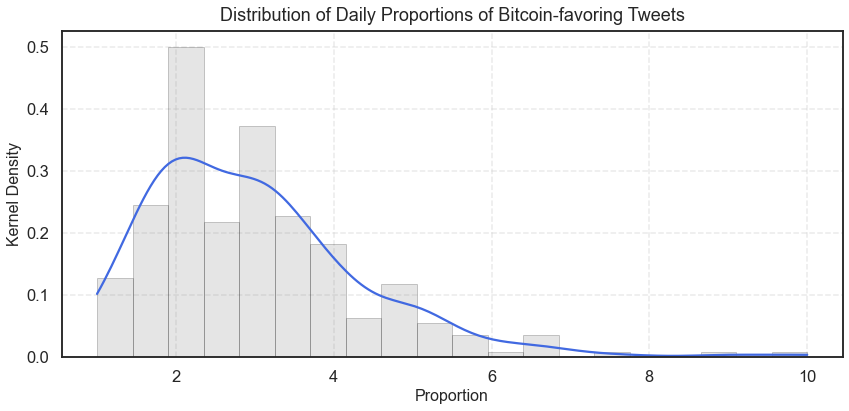

In [73]:
def helper_distplot(data, bw_adjust, bins, title='TITLE', xlabel = 'XLABEL', ylabel = 'Kernel Density', figsize=(14, 6)):
    """
    This dist_plot function visualizes the distribution of the data in histograms and KDE curve. 
    
    Input:
        data: pandas series. The variable.
        bw_adjust: float. KDE parameter. Factor that multiplicatively scales the value chosen using bw_method. Increasing will make the curve smoother.
        bins: int. Number of bars.
        title: string. Title of the graph.
        xlabel: string. The title of the x-axis
        ylabel: string. The title of the y-axis. Note that y-axis stands for the Kernel Density, which corresponds to the histogram bin width and thus could take values greater than 1, rather than the actual probability.
        figsize: tuple. The width and height of the figure.
    Output:
        fig: figure object.
    """
    fig,ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.distplot(data,
                 label = 'XXX', 
                 ax = ax, 
                 color = 'royalblue',
                 bins = bins,  
                 kde = True,               
                 kde_kws = {                     
                     'bw_adjust': bw_adjust,
                     # Factor, multiplied by the smoothing bandwidth, that determines how far the evaluation grid extends past the extreme datapoints. 
                     # When set to 0, truncate the curve at the data limits.
                     'cut': 0, 
                     'clip': [data.min(),data.max()]  
                 },
                 hist_kws={
                     'histtype': 'bar',
                     'color': 'grey',   
                     'edgecolor': 'black',               
                     'linewidth': 1,    
                     'alpha': 0.2
                 }                                
    )
    ax.set_title(title, fontsize = 18, pad = 10)
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.grid(linestyle = "--", alpha=0.4)

    plt.show()   
    # return fig

# Test
helper_distplot(
    data = df['tip'],
    bw_adjust = 1, 
    bins = 20,
    title='Distribution of Daily Proportions of Bitcoin-favoring Tweets', 
    xlabel = 'Proportion', 
    ylabel = 'Kernel Density', 
    figsize=(14, 6)
)

#### Boxplot

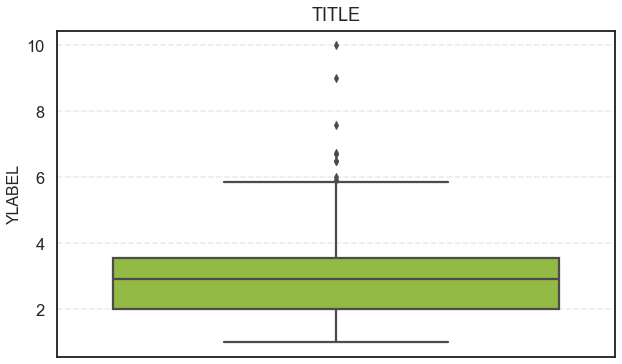

In [81]:
def helper_boxplot(data, title, ylabel, figsize = (10,6)):

    fig, _ = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.boxplot(data = data, color = "yellowgreen")
    plt.grid(linestyle = "--", alpha=0.4)
    plt.title(title, fontsize = 18, pad = 10)
    plt.ylabel(ylabel, fontsize = 16)
    plt.xticks([]) # remove the labels on the x-axis 
    plt.show()
    # return fig

# ==============================
# ----------- Test -------------
# ==============================
helper_boxplot(df['tip'], "TITLE", "YLABEL")

### Bi-Variate

#### Scatter Plot

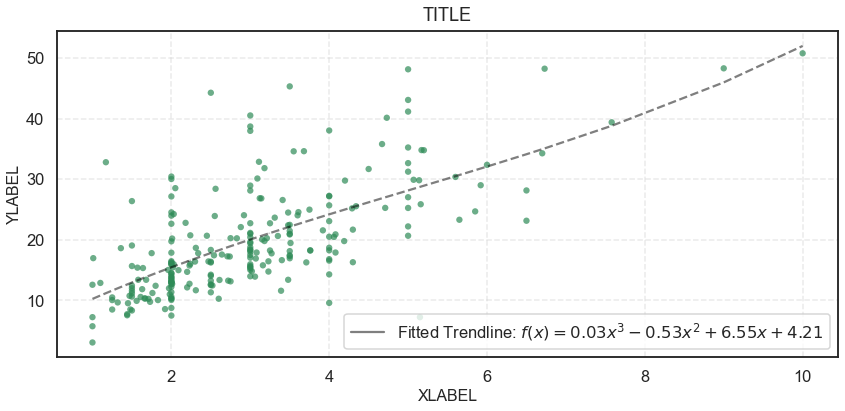

In [72]:
from scipy.optimize import curve_fit
import sympy as sym

def func_exp(x, a, b, c):
    return a * np.exp(b * x) + c
def func_log(x, a, b, c):
    return a * np.log(b * x) + c
def func_poly2(x, a, b, c):
    return a*x + b*x**2 + c
def func_poly3(x, a, b, c, d):
    return a*x + b*x**2 + c*x**3 + d

def helper_scatterlineplot(df, col_x, col_y, fitted_func = func_poly3, title='TITLE', xlabel = 'XLABEL', ylabel = 'YLABEL', figsize=(14, 6)):
    """
    This scatterplot function visualizes the distribution each individual data points by two variables 
    as well as a fitted trendline. 
    
    Input:
        df: pandas dataframe. The dataset.
        col_x: string. The first variable name from df as the x-axis.
        col_y: string, The second variable name from df as the y-axis.
        fitted_func: function. The desired fitted function.
        title: string.
        xlabel: string. The title of the x-axis
        ylabel: string. The title of the y-axis
        figsize: tuple. The width and height of the figure.
    Output:
        fig: figure object.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    # Scatter Plot
    sns.scatterplot(
        x=col_x,
        y=col_y, 
        data = df,
        ax=ax,
        size=10,
        legend = None,
        linewidth = 0, # get ride of the surrounding frame
        alpha=0.7, # make it transparent so I could tell the density by how dark the color is.
        color = 'seagreen'
    )
    
    # Get the fitted parameters
    popt, _ = curve_fit(func_poly3, df[col_x], df[col_y])
    
    xs = sym.Symbol('x')    
    tex = sym.latex(func_poly3(xs,*[round(i,2) for i in popt])).replace('$', '')

    # Fitted Trendline
    sns.lineplot(
        x = df[col_x],
        y = func_poly3(df[col_x], *popt), 
        ax = ax,
        # Use sympy to generate the LaTeX syntex of the function
        label = r'Fitted Trendline: $f(x)= %s$' %(tex),
        color = 'black',
        alpha = 0.5
    )
    ax.lines[0].set_linestyle("--")
    
    ax.set_title(title,fontsize=18, pad = 10)
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.grid(linestyle="--", alpha=0.4)
    plt.show() 
    

# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("tips")

helper_scatterlineplot(
    df = df, 
    col_x = 'tip',
    col_y = 'total_bill',
    fitted_func = func_poly3,
    title = "TITLE",
    xlabel = "XLABEL",
    ylabel = "YLABEL",
    figsize = (14,6)
)

### Multi-Variate

#### Correlation Matrix

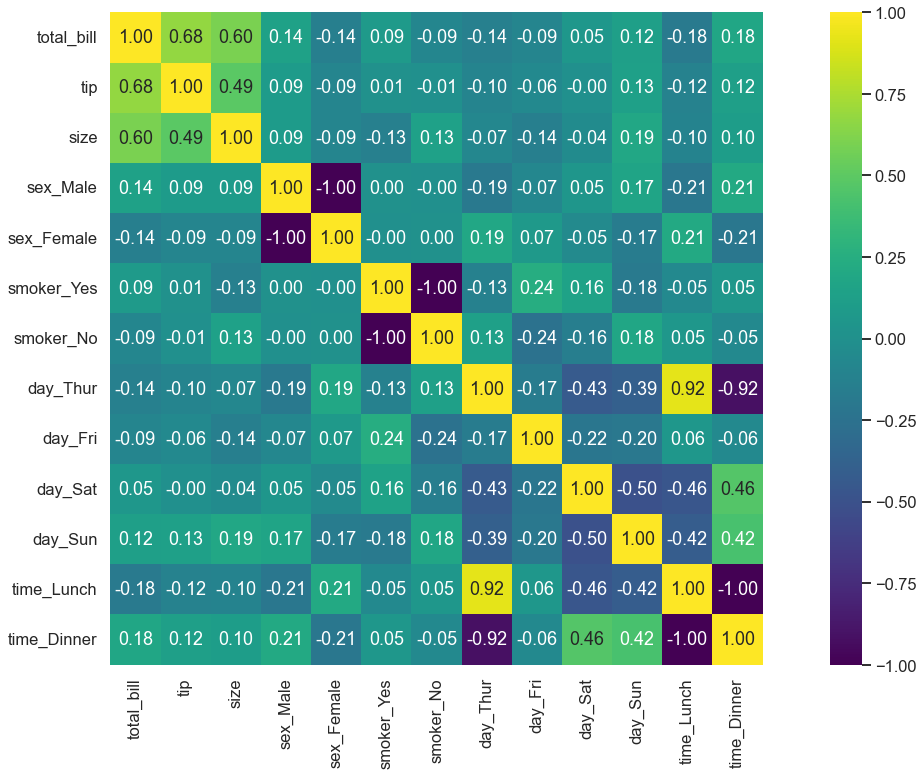

In [77]:
# Multi-variate analysis
corr_data = pd.get_dummies(df).corr()
plt.subplots(figsize=(24,12))
sns.heatmap(corr_data, annot=True, vmax=1, square=True, fmt='.2f',
            cmap = sns.color_palette("viridis", as_cmap=True)
)
plt.show()

#### Scatter Matrix

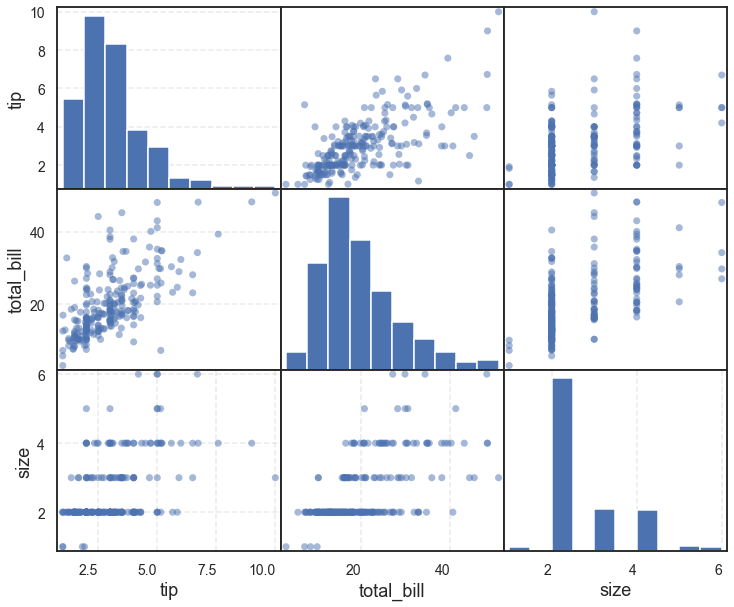

In [223]:
def helper_scattermatrix(df, cols):    
    '''
    Input:
        df: pandas dataframe
        cols: a list of columns
    '''
    scatter_matrix_fig = pd.plotting.scatter_matrix(
        df[cols], 
        marker='o',
        s = 50,
        alpha = 0.5,
        figsize = (12,10),
        range_padding=0.05)

    for ax in scatter_matrix_fig.ravel():
        plt.setp(ax.get_xticklabels(), fontsize = 14, rotation=360, ha="right")
        plt.setp(ax.get_yticklabels(), fontsize = 14, ha="right")
        ax.grid(linestyle="--", alpha=0.4)

    plt.show()

# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("tips")

helper_scattermatrix(df, ['tip','total_bill','size'])

### Segmentation Analysis

#### Category X v.s. Target Y

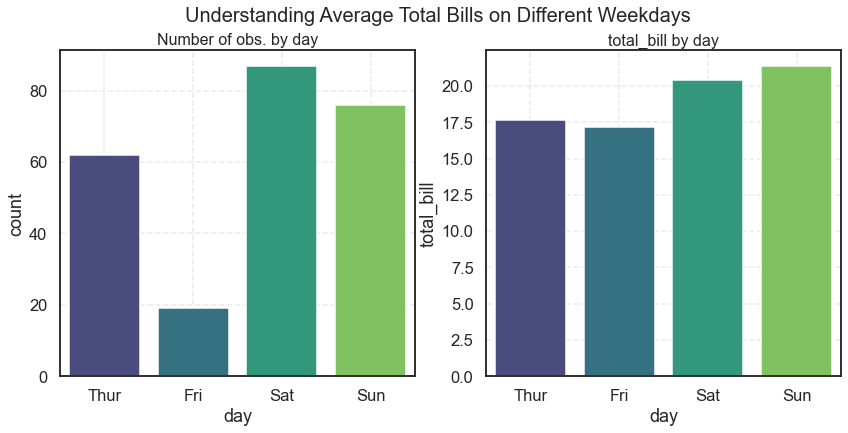

In [83]:
def helper_catplot(df,col_cat,col_y,suptitle, figsize=(14,6)):
    '''
    This helper function integrates boxplot, barchart, distribution-plot all together. 
    The plot_type parameter controls the output graph format.
    
    Input:
        df: pandas dataframe
        col_cat: string. the column name of the key categorical variable (key dimension).
        col_y: string. the column name of the dependent variable (key metric).
        figsize: tuple. The width and height of the figure.
    Output:
        fig: figure object.
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    sns.countplot(
        x=col_cat, 
        data=df,
        ax=axes[0],
        palette=sns.color_palette("viridis",df[col_cat].nunique())
    )
    axes[0].set_title(f'Number of obs. by {col_cat}', fontsize=16, pad = 5)
    axes[0].grid(linestyle="--", alpha=0.4)

    sns.barplot(
        x=col_cat, 
        y=col_y, 
        data=df, 
        ci=0, 
        ax=axes[1],
        estimator = np.mean,
        palette=sns.color_palette("viridis",df[col_cat].nunique())
    );
    axes[1].set_title(f'{col_y} by {col_cat}', fontsize = 16, pad = 5)
    axes[1].grid(linestyle="--", alpha=0.4)

    fig.suptitle(suptitle, fontsize = 20)
    plt.show()
    
    # return fig

# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("tips")

helper_catplot(
    df = df,
    col_cat = 'day',
    col_y = 'total_bill',
    suptitle = "Understanding Average Total Bills on Different Weekdays"
)

# fig.savefig(
#     fname = "../categorical_bar_plot_series.png", # path&filename for the output
#     dsi = 300, # make it a high-resolution graph
#     bbox_inches='tight' # sometimes default savefig method cuts off the x-axis and x-ticks. This param avoids that 
# )

#### Continuous X v.s. Class Y

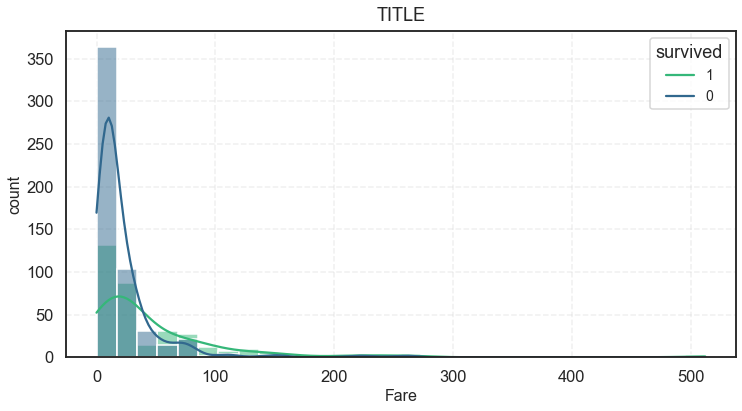

In [161]:
def helper_twoclass_histograms(df, col_group, col_metric, xaxis_label, title, stat, bins):
    '''
    This helper function is designed to reveal the difference in {col_metric} distribution between the two classes {col_group}
    in the classification problem context.
    '''
    group_list = list(df[col_group].unique())
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    
    # Histogram plot for the first numerical variable
    sns.histplot(
        x= col_metric,
        hue = col_group, 
        hue_order = group_list, # sns.histplot has some difficulty displaying the legends, especially when hue parameter is specified, so we should explicitly pass the hue_orders
        data = df, 
        stat= stat, # show y-axis in percentage form rather than density
        bins = bins,
        alpha = 0.5,
        ax=ax,
        palette=sns.color_palette("viridis",len(group_list)), 
        kde = True    
    )
    
    if stat == 'percent':
        ax.yaxis.set_major_formatter(PercentFormatter(100,decimals=0)) # Format the percentage.
    ax.set_title(title, fontsize=18,pad= 10)
    ax.set_xlabel(xaxis_label,fontsize = 16)
    ax.set_ylabel(stat,fontsize = 16)
    ax.legend(title = col_group, labels = group_list[::-1],fontsize = 14) # The actual labels/legends are in the reverse orders.
    ax.grid(linestyle="--", alpha=0.3)
    plt.show()    


# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("titanic")

helper_twoclass_histograms(
    df = df, 
    col_group = 'survived', 
    col_metric = 'fare', 
    xaxis_label = 'Fare', 
    title = "TITLE", 
    stat = 'count', 
    bins = 30
)

### Time Series Trend

#### Time Sereis Trend Plot (Seaborn)

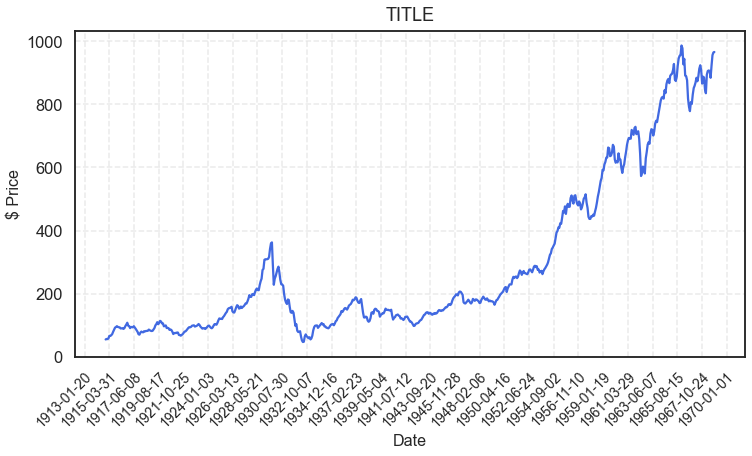

In [141]:
def helper_tsplot(df, col_x, col_y, ticks_param, title='TITLE', xlabel = 'XLABEL', ylabel = 'LEFT_YLABEL', figsize=(14, 6)):
    '''
    This lineplot function visualizes the (time series) trend of key metrics. 
    It is worth noting that the col_x needs to be in datetime[64n] format because we apply shrinking tricks on the xticks
    
    Input:
        df_1: pandas dataframe. The dataframe for the first variable.
        col_x: string. The name of the column in df_1 as the x-axis
        col_y: string. The name of the column in df_1 as the left x-axis 

        title: string. The title of the diagram
        xlabel: string. The name of the x-axis
        ylabel: string. The title of the left y-axis
        figsize: tuple. The width and height of the figure.
    
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)
    
    # Lineplot for the first variable (left axis)
    sns.lineplot(
        x = col_x, y = col_y,
        data = df, ax = ax,
        color = 'royalblue',
        # marker = "o", markersize = 6,
        
    )
    ax.set_xlabel(xlabel,fontsize = 16)
    ax.set_ylabel(ylabel,fontsize = 16)
    # Display 7 times fewer ticks on the x-axis to avoid the overlapping mess
    ax.xaxis.set_major_locator(ticker.MultipleLocator(ticks_param))
    # Rotate the x-ticks to save some space
    plt.setp(ax.get_xticklabels(), fontsize = 14, rotation=45, ha="right", rotation_mode="anchor")

    # Add auxiliary lines and auxiliary shaded area (if needed)
#     ax.axvspan(
#         xmin = datetime.strptime('2019/09/26', '%Y/%m/%d'), 
#         xmax = datetime.strptime('2019/09/30', '%Y/%m/%d'), 
#         color = 'darkgrey',
#         alpha=0.2)
    # ax.axhline(y = 0.5, ls = "--", c = "black",alpha = 0.6) #
    # ax.axvline(x = datetime.strptime('2019/09/28', '%Y/%m/%d'), ls = "--", c = "black",alpha = 0.6) 
    
    # Format the graph-level features 
    ax.set_title(title, fontsize=18, pad=10) # pad paramter increases the space between title and graph (https://stackoverflow.com/questions/16419670/increase-distance-between-title-and-plot-in-matplolib)
    # Faint the grid lines
    ax.grid(linestyle="--", alpha=0.4)
    # ax.tick_params(top=False)    
    plt.show()
    
    return fig

# ==============================
# ----------- Test -------------
# ==============================
# Load the data
df = sns.load_dataset('dowjones')
df.Date = df.Date.astype('datetime64')

fig = helper_tsplot(
    df = df, 
    col_x = 'Date', 
    col_y = 'Price', 
    ticks_param = 800,
    title='TITLE', 
    xlabel = 'Date', 
    ylabel = '$ Price',    
    figsize=(12, 6)
)

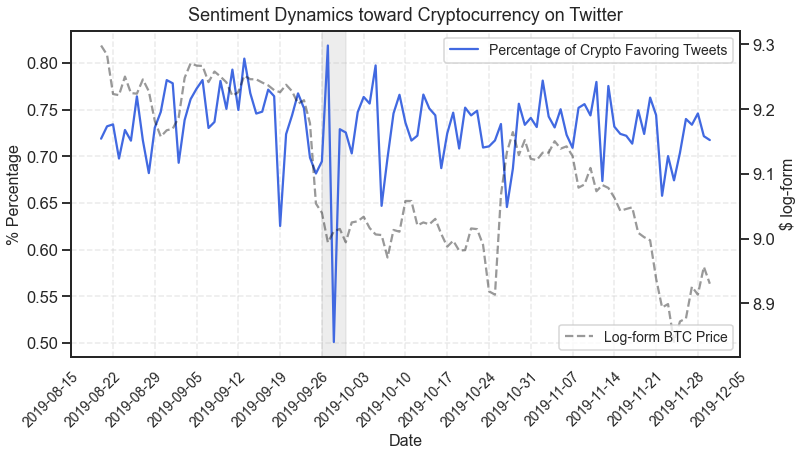

In [107]:
def helper_twotsplot(df_1, col_x, col_1_y, line_1_label, df_2, col_2_y, line_2_label, title='TITLE', xlabel = 'XLABEL', y_1_label = 'LEFT_YLABEL',y_2_label = 'RIGHT_YLABEL', figsize=(14, 6)):
    '''
    This lineplot function visualizes the (time series) trend of key metrics col_1_y versus col_2_y over col_x.
    col_1_y corresponds to the left y-axis and col_2_y is ties to the right y-axis.
    I also keep the alternative to add a shaded area / auxiliary lines to the graph.
    
    Input:
        df_1: pandas dataframe. The dataframe for the first variable.
        col_x: string. The name of the column in df_1 as the x-axis
        col_1_y: string. The name of the column in df_1 as the left x-axis 
        line_1_label: string. The label for col_1_y that appears as legends
        
        df_2: pandas dataframe. The dataframe for the second variable.
        col_2_y: string. The name of the column in df_2 as the right x-axis 
        line_2_label: string. The label for col_2_y that appears as legends  
        
        title: string. The title of the diagram
        xlabel: string. The name of the x-axis
        y_1_label: string. The title of the left y-axis
        y_2_label: string. The title of the right y-axis
        figsize: tuple. The width and height of the figure.
    
    '''
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize = figsize)
    
    # Lineplot for the first variable (left axis)
    sns.lineplot(
        x = col_x, y = col_1_y,
        data = df_1, ax = ax,
        color = 'royalblue',
        label = line_1_label,
        # marker = "o", markersize = 6,
        
    )
    ax.set_xlabel(xlabel,fontsize = 16)
    ax.set_ylabel(y_1_label,fontsize = 16)
    # Set the legend location and fontsize
    ax.legend(loc=0,fontsize=14)
    # Display 7 times fewer ticks on the x-axis to avoid the overlapping mess
    ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
    # Rotate the x-ticks to save some space
    plt.setp(ax.get_xticklabels(), fontsize = 14, rotation=45, ha="right", rotation_mode="anchor")

    
    # Lineplot for the second variable (right axis)
    ax_y = ax.twinx()
    sns.lineplot(
        x = col_x, 
        y = col_2_y, 
        data = df_2,
        ax = ax_y, 
        label = line_2_label,
        color = 'black',
        alpha = 0.4,
        # linestyle = 'dashed',
        # marker='o',markersize= 6,
    )
    # Display 7 times fewer ticks on the x-axis to avoid the overlapping mess
    ax_y.xaxis.set_major_locator(ticker.MultipleLocator(7))
    # Rotate the x-ticks to save some space
    plt.setp(ax_y.get_xticklabels(), fontsize = 14, rotation=45, ha="right", rotation_mode="anchor")
    ax_y.set_ylabel(y_2_label,fontsize = 16)
    # Make it a dashed lineplot (https://stackoverflow.com/questions/51963725/how-to-plot-a-dashed-line-on-seaborn-lineplot) 
    ax_y.lines[0].set_linestyle("--")
    # Set the legend location and fontsize
    ax_y.legend(loc=4,fontsize = 14)


    # Add auxiliary lines and auxiliary shaded area (if needed)
    ax.axvspan(
        xmin = datetime.strptime('2019/09/26', '%Y/%m/%d'), 
        xmax = datetime.strptime('2019/09/30', '%Y/%m/%d'), 
        color = 'darkgrey',
        alpha=0.2)
    # ax.axhline(y = 0.5, ls = "--", c = "black",alpha = 0.6) #
    # ax.axvline(x = datetime.strptime('2019/09/28', '%Y/%m/%d'), ls = "--", c = "black",alpha = 0.6) 
    
    # Format the graph-level features 
    ax.set_title(title, fontsize=18, pad=10) # pad paramter increases the space between title and graph (https://stackoverflow.com/questions/16419670/increase-distance-between-title-and-plot-in-matplolib)
    # Faint the grid lines
    ax.grid(linestyle="--", alpha=0.4)
    # ax.tick_params(top=False)    
    plt.show()
    
    return fig

# ==============================
# ----------- Test -------------
# ==============================
# Load the data
price = pd.read_csv("https://raw.githubusercontent.com/mintaow/MyMediumWork/main/4_useful_seaborn_viz_templates/data/daily_btc_price.csv",parse_dates = ['date'],index_col=0)
ts1 = pd.read_csv("https://raw.githubusercontent.com/mintaow/MyMediumWork/main/4_useful_seaborn_viz_templates/data/daily_crypto_sentiment.csv",parse_dates = ['date'],index_col=0)

fig = helper_twotsplot(
    df_1 = ts1, 
    col_x = 'date', 
    col_1_y = 'perc_btc_favor_tweets', 
    line_1_label = 'Percentage of Crypto Favoring Tweets', 
    df_2 = price, 
    col_2_y = 'log_avg_price', 
    line_2_label = 'Log-form BTC Price', 
    title='Sentiment Dynamics toward Cryptocurrency on Twitter', 
    xlabel = 'Date', 
    y_1_label = '% Percentage',
    y_2_label = '$ log-form', 
    figsize=(12, 6)
)

#### Time Sereis Trend Plot (Plotly)

In [90]:
def helper_tsplot_plotly(df, date_col, y_col, title_text, xaxis_title, yaxis_title, mode = 'lines'):
    '''
    Caveat: The hover label needs additional customization based on the context.
    Input:
        df,
        date_col,
        y_col,
        title_text,
        xaxis_title
        yaxis_title
    Output:
        fig1 (Plotly.graph figure object)
    '''    
    # filter the data according to the user-specified thresholds
    data = df.loc[:, [date_col,y_col]]

    x = list(data[date_col])
    y = list(data[y_col])

    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig1 = go.Figure(layout = layout)

    # add the actual line
    fig1.add_trace(go.Scatter(
        x=x, y=y,
        # line_color='rgb(0,100,80)', # green
        # line_color='rgb(0,176,246)', # blue
        # line_color='rgb(242,142,43)', # orange
        line_color='rgb(176,122,161)', # purple
        # name='...',
        showlegend=False,
        hovertemplate =
          '<b>Precipitation: </b> %{y:.2f} mm'+
          '<br><b>Hour</b>: %{x}<br>'
    ))

    # Set the layout
    fig1.update_layout(
        height=600,
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        yaxis=dict(
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ),            
        ),
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "date"
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
    annotations = []
    # Adding labels
    # Title
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=f'{title_text}',
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig1.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_traces(mode=mode)
    fig1.update_layout(annotations=annotations)
    return fig1

# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("dowjones")
helper_tsplot_plotly(df, 
                      'Date',
                      'Price', 
                      "TITLE", 
                      'XAXIS', 
                      'YAXIS', mode = 'lines')

In [114]:
def helper_twotsplot_plotly(df_1, date_col, y1_col, df_2, y2_col, title_text, xaxis_title, yaxis1_title, yaxis2_title, mode = 'lines'):
    '''
    Input:
        df,
        date_col,
        y1_col,
        y2_col,
        title_text,
        xaxis_title,
        yaxis_title
    Output:
        fig1 (Plotly.graph figure object)
    '''    
    x = list(df_1[date_col])
    y1 = list(df_1[y1_col])
    y2 = list(df_2[y2_col])


    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis = dict(title = 'Last Mile Latency (ms)'),
        yaxis2 = dict(title = 'Precipitation (mm)',overlaying = 'y',side = 'right')
    )

    fig1 = go.Figure(layout = layout)

    # add primary line
    fig1.add_trace(go.Scatter(
        x=x, y=y1,
        line_color = px.colors.qualitative.Set2[0],
        name=y1_col,
        showlegend=False,
        yaxis = 'y1',
        hovertemplate =
          '<b>Last Mile Latency: </b> %{y:.2f} ms'+
          '<br><b>Timestamp</b>: %{x}<br>'
    ))
    # add secondary line
    fig1.add_trace(go.Scatter(
        x=x, y=y2,
        line_color = px.colors.qualitative.Set2[2],
        name=y2_col,
        showlegend=False,     
        yaxis = 'y2',
        hovertemplate =
          '<b>Precipitation: </b> %{y:.2f} mm'+
          '<br><b>Timestamp</b>: %{x}<br>'
    ))    

    # Set the layout
    fig1.update_layout(
        height=600,
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title=xaxis_title,
        yaxis=dict(
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ), 
            title = yaxis1_title
        ),
        yaxis2 =dict(
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ), 
            title = yaxis2_title,
            overlaying = 'y',
            side = 'right'
        ),        
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "date"
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
    annotations = []
    # Adding labels
    # Title
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=f'{title_text}',
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig1.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_traces(mode=mode)
    fig1.update_layout(annotations=annotations)
    return fig1

# ==============================
# ----------- Test -------------
# ==============================
# Load the data
price = pd.read_csv("https://raw.githubusercontent.com/mintaow/MyMediumWork/main/4_useful_seaborn_viz_templates/data/daily_btc_price.csv",parse_dates = ['date'],index_col=0)
ts1 = pd.read_csv("https://raw.githubusercontent.com/mintaow/MyMediumWork/main/4_useful_seaborn_viz_templates/data/daily_crypto_sentiment.csv",parse_dates = ['date'],index_col=0)

fig = helper_twotsplot_plotly(
    df_1 = ts1, 
    date_col = 'date',
    y1_col = 'perc_btc_favor_tweets', 
    df_2 = price, 
    y2_col = 'log_avg_price', 
    title_text = 'Sentiment Dynamics toward Cryptocurrency on Twitter', 
    xaxis_title = 'Date', 
    yaxis1_title = '% Percentage', 
    yaxis2_title = '$ Log-form', 
    mode = 'lines'
)
fig

## Datasets

### Imputing Missing Values

#### KNN Imputation

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
df= pd.DataFrame(imputer.fit_transform(df))

#### Mean Imputation

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df= pd.DataFrame(imputer.fit_transform(df))

## Hypothesis Testing

### Check Distribution being Normal

In [277]:
from scipy.stats import norm 

def check_normal_dist(data1, data2, method):
    '''
    This function checks whether two series (data1 and data2) is sampled from normal distribution 
    via different methods to ensure robustness.
    '''
    if method == 'ks_test':
        # 1. Check Kolmogorov-Smirnov test result
        # H0: The sample is drawn from a normal distributed population
        print("KS-Test for the treatment group: ",stats.kstest(data1, 'norm'))
        print("KS-Test for the control group: ",stats.kstest(data2, 'norm'),"\n")
    elif method == 'shapiro':
        # 2. Check Shaporio-Wilk test result
        # H0: The sample is drawn from a normal distributed population
        print(f'Shapiro–Wilk test for the treatment group: The p-value is {stats.shapiro(data1)[1]}')
        print(f'Shapiro–Wilk test for the control group: The p-value is {stats.shapiro(data2)[1]}')
    elif method == 'qq_plot':
        # 3. Visualize normality using Q-Q plot
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
        stats.probplot(data1, dist="norm", plot=axes[0])
        axes[0].set_title("Treatment Group: Q-Q Plot", fontsize = 16)
        stats.probplot(data2, dist="norm", plot=axes[1])
        axes[1].set_title("Control Group: Q-Q Plot", fontsize = 16)
        fig.suptitle("Q-Q Plot Normality Check", fontsize = 20)
    elif method == 'hist':
        # 4. Visualize normality using histogram    
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,10))
        sns.distplot(data1,
                  hist_kws = {'histtype': 'bar', "color": 'green','alpha': 0.4},
                  kde_kws={"lw": 2,"alpha":0.8,"linestyle":'--'},
                  ax=axes[0])
        axes[0].set_xlabel('X') 
        axes[0].set_ylabel('Probability')
        axes[0].set_title(f'Treatment Group: Histogram',fontsize = 16) 
        sns.distplot(data2,
                  hist_kws = {'histtype': 'bar', "color": 'green','alpha': 0.4},
                  kde_kws={"lw": 2,"alpha":0.8,"linestyle":'--'},
                  ax=axes[1])
        axes[1].set_xlabel('X')  
        axes[1].set_ylabel('Probability') 
        axes[1].set_title(f'Control Group: Histogram',fontsize = 16) 
        
    elif method == 'hist_norm':
        # 5. Visualize normality using histogram (normal distribution as fde)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,10))
        num_bins = 50  

        mu =np.mean(data1) 
        sigma =np.std(data1) 
        n, bins, patches = axes[0].hist(data1, num_bins,facecolor='green', alpha=0.5) 
        y = norm.pdf(bins, mu, sigma) 
        axes[0].plot(bins, y, 'b--') 
        axes[0].set_xlabel('X')
        axes[0].set_ylabel('Probability')
        axes[0].set_title(f'Treatment Group: Histogram(mu = {round(mu)}; sigma = {round(sigma)})',fontsize = 16) 

        mu =np.mean(data2) 
        sigma =np.std(data2)  
        n, bins, patches = axes[1].hist(data2, num_bins,facecolor='green', rwidth = 0.7,alpha=0.5) 
        y = norm.pdf(bins, mu, sigma)
        axes[1].plot(bins, y, 'b--') 
        axes[1].set_xlabel('Active Minutes') 
        axes[1].set_ylabel('Probability')
        axes[1].set_title(f'Control Group: Histogram (mu = {round(mu)}; sigma = {round(sigma)})',fontsize = 16) 
        fig.suptitle("Histogram Normality Check \n Note: The blue curve depicts normal distribution ", fontsize = 20)        
    else:
        print("Unrecognized Method")  

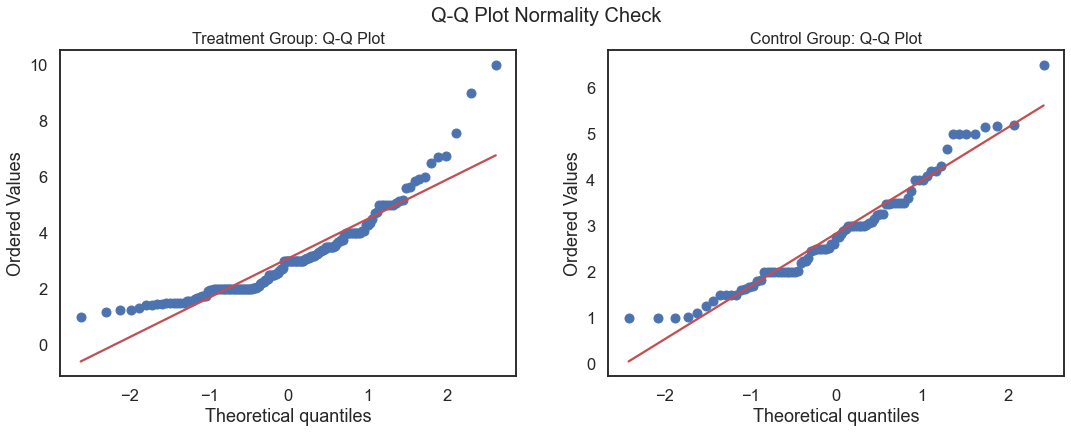

In [278]:
# ==============================
# ----------- Test -------------
# ==============================
check_normal_dist(
    data1 = df.loc[df.sex == 'Male','tip'], 
    data2 = df.loc[df.sex == 'Female','tip'],  
    method = 'qq_plot'
)

### Check Homogeneous Variance

In [ ]:
def check_homo_var(data1, data2):
    '''
    This function checks the homogeneous variance assumption for independent t-test, 
    which is required if implementing AB experiment.
    
    H0: all input samples are from populations with equal variances. 
    '''
    # Check levene test result
    t,p = stats.levene(data1,data2)
    print(f"Levene variance test: t={round(t,3)}, p={round(p,3)}")


### Check Sampling Distribution being Random

In [ ]:
def plot_samp_dist(data, metric_col, dim_col, group_col,id_col,fig_size = [22,10],matrix=[1,2]):
    '''
    Use Case: Test Simpson Paradox
    '''
    fig, axes = plt.subplots(nrows=matrix[0], ncols=matrix[1], figsize=(fig_size[0], fig_size[1]))

    SIZE_EXPT = data[data[group_col] == 1][id_col].nunique()
    SIZE_CTRL = data[data[group_col] == 0][id_col].nunique()

    tmp_by_dim = data.groupby(by=[dim_col,group_col,id_col])[metric_col].sum().reset_index().groupby(by= [dim_col,group_col]).agg(
        {id_col:"nunique",metric_col:"mean"}).reset_index().sort_values(id_col,ascending = False)
    tmp_by_dim.columns = [dim_col,group_col,"cnt_"+id_col,metric_col]
    tmp_by_dim[dim_col+'_pct'] = 0
    tmp_by_dim.loc[tmp_by_dim[group_col] == 1,dim_col+'_pct'] = tmp_by_dim[tmp_by_dim[group_col] == 1]["cnt_"+id_col]/SIZE_EXPT
    tmp_by_dim.loc[tmp_by_dim[group_col] == 0,dim_col+'_pct'] = tmp_by_dim[tmp_by_dim[group_col] == 0]["cnt_"+id_col]/SIZE_CTRL

    sns.barplot(x=dim_col, y = dim_col+'_pct', hue = group_col, data=tmp_by_dim,
                ax=axes[0], palette=sns.color_palette("viridis", 2))
    axes[0].set_title(f'Sampling Distribution by {dim_col}', fontsize=18)
    axes[0].grid(linestyle="--", alpha=0.2)
    axes[0].legend(title = "Ctr=0/Exp=1",loc = 1)

    sns.barplot(x=dim_col, y=metric_col,hue = group_col, data=tmp_by_dim, 
                ci=0, ax=axes[1], palette=sns.color_palette("viridis", 2))
    axes[1].set_title(f'Active Minutes per User by {dim_col}', fontsize=18)
    axes[1].grid(linestyle="--", alpha=0.2)
    axes[1].legend(title = "Ctr=0/Exp=1",loc = 1)

    fig.suptitle(f"Random Sampling Check on {dim_col}: Comparing Experiment/Control Group",fontsize = 20)
    plt.show()    

### Statistical Test

#### t-test

In [281]:
from scipy import stats

def levene_t_test(data1, data2):
    # Step1: Check normal distribution assumption (Skip)
    # print("Data1: KS-Test",stats.kstest(data1, 'norm'))
    # print("Data1: KS-Test",stats.kstest(data2, 'norm'),"\n")
    
    # Step2: Check equality of variance (not required in paired t-test), only required in independent t-test
    t_var,p_var = stats.levene(data1,data2)
    # print(f"Levene variance test: t={round(t_var,3)}, p={round(p_var,3)}")
    if p_var<0.05:
        print("----variance of the two group doesn't equal, reject the null hypothesis----")
        t,p = stats.ttest_ind(data1,data2, equal_var = False)
    else:
        t,p = stats.ttest_ind(data1,data2)
    print("H0: There is no statistically significant difference in the population mean.\n------------")
    print(f"Independent t-test: t={round(t,3)}, p={round(p,3)}")
    
# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("tips")
levene_t_test(
    data1 = df.loc[df.sex == 'Male','tip'], 
    data2 = df.loc[df.sex == 'Female','tip'],  
)

H0: There is no statistically significant difference in the population mean.
------------
Independent t-test: t=1.388, p=0.166


#### ANOVA

In [294]:
from scipy import stats
def anova_test(df, group_col, metric_col):
    '''
    Input:
        df: test dataframe (pandas df)
        group_col: the group column
        metric_col: the metric column
        
    '''
    args = []
    for group_value in df[group_col].unique():
        args.append(df.loc[df[group_col] == group_value, metric_col].values)    
    f, p = stats.f_oneway(*args)

    print(f'For group variable {group_col}: One-way ANOVA')
    print('=============')

    print('F value:', round(f,4))
    print('P value:', round(p,4))

# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset("tips")
anova_test(
    df = df,
    group_col = 'day',
    metric_col = 'tip'
)    

For group variable day: One-way ANOVA
F value: 1.6724
P value: 0.1736


#### Minimum Sample Size Calculation

In [305]:
from scipy.stats import norm
def sampleSize_twoGroups(mu, mde_perc_lift, alpha=0.05, beta=0.2, sigma1=1, sigma2=1):
    '''
    Sample size for two groups
    '''
    mde = mu*mde_perc_lift
    n = np.round((norm.ppf(1-alpha/2.) + norm.ppf(1-beta))**2 * (sigma1**2 + sigma2**2) / (mde)**2)
     
    print(('In order to detect a change of {0} between groups with an SD of {1} and {2},'.format(mde, sigma1, sigma2)))
    print(('with significance {0} and test-power {1}%, you need in each group at least {2:d} subjects.'.format(alpha, 100*(1-beta), int(n))))
     
    return n

In [306]:
# ==============================
# ----------- Test -------------
# ==============================
sampleSize_twoGroups(
    mu = 0.02,
    mde_perc_lift = 0.05,
    alpha=0.05, beta=0.2, sigma1=1, sigma2=1
)

In order to detect a change of 0.001 between groups with an SD of 1 and 1,
with significance 0.05 and test-power 80.0%, you need in each group at least 15697759 subjects.


15697759.0

#### F-test (TBD)

In [295]:
#define F-test function
def f_test(x, y):
    '''
    The f_test returns the f-statistic as well as the p-value. 
    Note that the F-test is extremely sensitive to non-normality of X and Y, so you're probably better off doing a more robust test such as Levene's test or Bartlett's test unless you're reasonably sure that X and Y are distributed normally. 
    
    Reference :https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python

    Input: 
      x: group A series
      y: group B series
    Output:
      a tuple of (f_stat, p) 
    '''
    x = np.array(x)
    y = np.array(y)
    # In standard statistical practice, ddof=1 provides an unbiased estimator of the variance of a hypothetical infinite population. ddof=0 provides a maximum likelihood estimate of the variance for normally distributed variables.
    f_stat = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic: F-Statistic is simply F = Var(X) / Var(Y)


    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = stats.f.cdf(f_stat, dfn, dfd) #find p-value of F test statistic 
    return f_stat, p

# Causal Inference

## PSM

In [ ]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
from scipy.stats import ttest_ind, ttest_rel


def psm_ttest(df, match_cols, treatment_col, index_col, outcome_col):
    """
    This psm_ttest(...) method matches the control group and treatment group using the PsmPy package
    and perform a paired t-test.
    
    The related methods/attributes include:
        psm.matched_ids => outputs matched results.
        psm.plot_match(...) => plot the distribution of propensity logits
        psm.effect_size_plot(save=False) => plot the effect size (Cohen's D)        
    """

    psm = PsmPy(df[match_cols+[treatment_col]+[outcome_col]+[index_col]], treatment=treatment_col, indx=index_col, exclude = [outcome_col])
    psm.logistic_ps(balance = True)
    psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)

    _, p = ttest_rel(df.loc[df.device_id.isin(psm.matched_ids.device_id),outcome_col], 
                     df.loc[df.device_id.isin(psm.matched_ids.matched_ID),outcome_col], 
                    )
    print(f'p={p:.3f}')
    
    return psm

# Time Series (To Be Updated)

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Stationarity & Cointegration

In [ ]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(df, col, maxlags):
    '''
    The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary. 

    p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
    '''
    print(f"Augmented Dickey-Fuller (ADF) Test: {col}")
    result = adfuller(df[col].dropna().values,maxlags)
    print('ADF Statistic: %f' % result[0])
    print("Used Lag: ",result[2])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("----------------------------------------")
    if result[1] <= 0.05:
        print(f" => P-Value = {result[1]}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {result[1]}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")     

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(df, col_name, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(df[col_name].dropna().values, 
                                                       regression="c")
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: {col_name} is {"not " if p_value < 0.05 else ""}stationary')
    print("------------------------------------------------------------------")

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """
    Perform Johanson's Cointegration Test and Report Summary
              
      Parameters
          endog array_like (nobs_tot x neqs)
          Data to test

      det_order int
          -1 - no deterministic terms
          0 - constant term
          1 - linear trend
          
      k_ar_diff int, nonnegative
          Number of lagged differences in the model.
    """
    out = coint_johansen(df,-1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(ts3[['cpi_month_diff','perc_btc_favor_tweets_diff','avg_price_month_diff']].dropna())

## PACF, ACF, and Residual Diagnosis

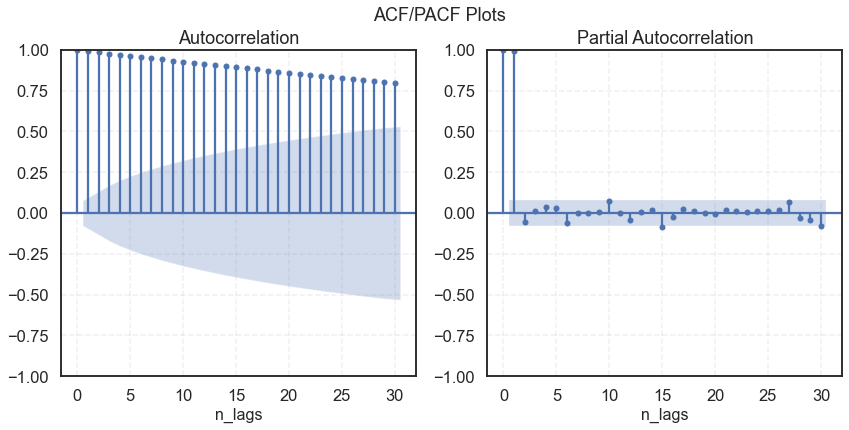

,lb_stat,lb_pvalue
20,11346.919356,0.0


In [6]:
def plot_acf_pacf(series,title="ACF/PACF Plots"):
    """
    plot_acf_pacf plots the ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Functions). 
    The input {series} is assumed to contain no nulls.    
    """
    f, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14,6))
    plot_acf(series, lags=30, ax = axes[0])
    plot_pacf(series, lags=30, ax = axes[1])
    axes[0].grid(linestyle="--", alpha=0.3)
    axes[1].grid(linestyle="--", alpha=0.3)
    axes[0].set_xlabel('n_lags',fontsize = 16)
    axes[1].set_xlabel('n_lags',fontsize = 16)
    f.suptitle(title,fontsize = 18)
    plt.show()

def resid_diag(resid, maxlags = 20):

    # Plot out the residual ACF/PACF
    plot_acf_pacf(resid,title="ACF/PACF Plots")
    # Conduct 
    return sm.stats.acorr_ljungbox(resid, 
                            lags = [maxlags],
                            return_df=True)
        
# ----------------------
# ------- Test ---------
# ----------------------    
# Load the data
df = sns.load_dataset('dowjones')
df.Date = df.Date.astype('datetime64')
resid_diag(df.Price)

In [7]:
# Calculate the Autocorrelation Table
def get_ts_stats(series):
    print("Included Observations:", len(series))
    ts_stats_df = pd.DataFrame()
    acf_values = acf(series, qstat=True)
    pacf_values = pacf(series)
    
    ts_stats_df['lags'] = [i for i in range(1,len(pacf_values[1:])+1)]
    ts_stats_df['ac'] =  acf_values[0][1:]
    ts_stats_df['pac'] =  pacf_values[1:]
    ts_stats_df['q_stat'] =  acf_values[1]
    ts_stats_df['p_val'] =   acf_values[2]

    return round(ts_stats_df,4)

# ----------------------
# ------- Test ---------
# ----------------------
# Load the data
df = sns.load_dataset('dowjones')
df.Date = df.Date.astype('datetime64')

ts_stats_df = get_ts_stats(df.Price)
ts_stats_df[:10]

Included Observations: 649


,lags,ac,pac,q_stat,p_val
0,1,0.9928,0.9943,642.6351,0.0
1,2,0.9850,-0.0545,1276.2189,0.0
2,3,0.9774,0.0099,1900.9764,0.0
3,4,0.9702,0.0365,2517.5628,0.0
4,5,0.9635,0.0304,3126.5704,0.0
5,6,0.9562,-0.0592,3727.3019,0.0
6,7,0.9488,-0.0015,4319.7349,0.0
7,8,0.9415,0.0029,4903.9914,0.0
8,9,0.9343,0.0058,5480.3078,0.0
9,10,0.9281,0.0709,6049.8209,0.0


## Time Series Forecasting: ARIMA, EM, FB Prophet

In [308]:
!pip install prophet

     |████████████████████████████████| 6.8 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 18.5 MB/s eta 0:00:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730985 sha256=9cb7b325035924e6d219d7ff91f34ac2bb62fdbf6841b3780073675557204948
  Stored in directory: /Users/mintaowei/Library/Caches/pip/wheels/33/3d/82/4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus


In [326]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from fbprophet import Prophet
from prophet import Prophet


def get_pred(train, valid, ts_col, y_col):
    FORECAST_TERM = len(valid)
    print("Number of future terms to forecast: ", FORECAST_TERM)

    arma_model = ARIMA(train[y_col], order=(1, 0, 1))
    arma_model_res = arma_model.fit()
    arma_pred = arma_model_res.forecast(FORECAST_TERM, alpha = 0.05) 
    arma_rmse = mean_squared_error(valid[y_col], arma_pred, squared=False)  

    es_fit = ExponentialSmoothing(
      train[[ts_col,y_col]].set_index(ts_col),
      trend="add",
      damped_trend = True,
      initialization_method="estimated",
    ).fit()
    es_pred = es_fit.forecast(FORECAST_TERM)
    es_rmse = mean_squared_error(valid[y_col], es_pred, squared=False)

    prophet_train = train[[ts_col, y_col]]
    prophet_train.columns = ['ds','y']    
    # Build the model
    prophet_model = Prophet(
      interval_width = 0.95,
      changepoint_prior_scale = 1.5,
      growth = 'linear',
      weekly_seasonality = True,
      daily_seasonality = True,
      yearly_seasonality = True
    )
    # prophet_model.add_country_holidays(country_name='US')
    # prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.01)
    prophet_model.fit(prophet_train)
    future_dt = prophet_model.make_future_dataframe(periods=FORECAST_TERM)
    prophet_pred = prophet_model.predict(future_dt)
    prophet_rmse = mean_squared_error(valid[y_col], prophet_pred.yhat[-FORECAST_TERM:],squared=False)

    model_lst = ['ARMA','EM','FB Prophet']
    rmse_lst = [arma_rmse, es_rmse, prophet_rmse]
    df = pd.DataFrame(columns = ['RMSE'],index=model_lst)    
    df['RMSE'] = rmse_lst
    return (df.sort_values(by='RMSE'),list(arma_pred),list(es_pred),list(prophet_pred.yhat[-FORECAST_TERM:]))

# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset('dowjones')
print(df.shape)
train = df[:500]
valid = df[500:]

res,_,_,_ = get_pred(train,valid,'Date','Price')
res


(649, 2)
Number of future terms to forecast:  149


/Users/mintaowei/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

21:09:22 - cmdstanpy - INFO - Chain [1] start processing
21:09:22 - cmdstanpy - INFO - Chain [1] done processing


,RMSE
EM,234.644638
ARMA,288.114122
FB Prophet,304.548272


In [331]:
def plot_ts_forecast(train, valid, ts_col, y_col):
    '''
    Input:
        train: training pandas dataframe
        valid: validation pandas dataframe
        ts_col
        y_col
        ...
    Output:
        fig2 (Plotly.graph figure object)
    '''           
    (rmse_df, arma_pred, es_pred, prophet_pred) = get_pred(train, valid, ts_col, y_col)
    print(rmse_df)

    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig2 = go.Figure(layout = layout)

    # add the actual scatter points
    fig2.add_trace(go.Scatter(
        x=list(valid[ts_col]), y=list(valid[y_col]),
        line_color='#393536',
        mode = 'markers',
        name='Actual Last Mile Latency',
        showlegend=True,
        hovertemplate =
          '<b>Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # add ARMA predictions
    fig2.add_trace(go.Scatter(
        x=list(valid[ts_col]), y=arma_pred,
        line_color='#113932',
        mode = 'lines+markers',
        name='ARMA',
        showlegend=True,
        hovertemplate =
          '<b>ARMA Predicted: Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # add Double Exponential Smoothing predictions
    fig2.add_trace(go.Scatter(
        x=list(valid[ts_col]), y=es_pred,
        line_color='#547e2a',
        mode = 'lines+markers',
        name='Double Exponential Smoothing',
        showlegend=True,
        hovertemplate =
          '<b>DEM Predicted: Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # add FB Prophet predictions
    fig2.add_trace(go.Scatter(
        x=list(valid[ts_col]), y=prophet_pred,
        line_color='#ffa600',
        mode = 'lines+markers',
        name='FB Prophet',
        showlegend=True,
        hovertemplate =
          '<b>FB Prophet Predicted: Last Mile Latency: </b> %{y} ms'+
          '<br><b>Datetime: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
    ))

    # Set the layout
    fig2.update_layout(
        font_family="Arial",
        height = 600,
        title_font_family="Arial",
        xaxis_title="Date",
        yaxis_title="Last Mile Latency",
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=16,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "date"
        ),
        yaxis = dict(tickfont = dict(size = 16)),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        )
    )

    # Title
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=f'Last Mile Latency (ms) | Anomaly Detection using Three-sigma Rule',
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig2.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig2.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig2.update_layout(annotations=annotations)
    return fig2


# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset('dowjones')
print(df.shape)
train = df[:500]
valid = df[500:]
plot_ts_forecast(train, valid, ts_col = "Date", y_col = 'Price')

(649, 2)
Number of future terms to forecast:  149


/Users/mintaowei/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

21:19:05 - cmdstanpy - INFO - Chain [1] start processing
21:19:05 - cmdstanpy - INFO - Chain [1] done processing


                  RMSE
EM          234.644638
ARMA        288.114122
FB Prophet  304.548272


## Facebook Prophet Deep-dive

Model Training

In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet import Prophet

m = Prophet(
      interval_width = 0.98,
      changepoint_prior_scale = 2,
      changepoint_range=0.8,    
      growth = 'linear',
      weekly_seasonality = False,
      daily_seasonality = False,
      yearly_seasonality = False    
)
prophet_df = df.loc[df.datetime>'2022-07-17',['datetime','last_mile_latency']]
prophet_df.columns = ['ds','y']    
# prophet_df['ds'] = list(map(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), prophet_df['ds']))
m.fit(prophet_df)

future = m.make_future_dataframe(periods = 40, freq = 'H') # Allow for sub daily time series data
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Visualization using Plotly (but it would be better to visualize using manually defined functions than `plot_plotly`)

In [ ]:
# Set the layout
layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = go.Figure(layout = layout)
fig = plot_plotly(
    m, 
    forecast
)

fig.update_layout(
    font_family="Arial",
    height = 600,
    title_font_family="Arial",
    xaxis_title="Date",
    yaxis_title="Last Mile Latency(ms)",
    xaxis=dict(    
        showline=True,
        showticklabels=True,
        linewidth=2,
        tickfont=dict(
            family='Arial',
            size=16,
            color='rgb(82, 82, 82)',
        ),
        rangeslider = dict(
            visible = True),
        type = "date"
    ),
    yaxis = dict(tickfont = dict(size = 16)),
    hoverlabel=dict(
        bgcolor="white",
        font_size=14,
        font_family="Arial"
    )
)

# Title
annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text=f'Last Mile Latency (ms) | Anomaly Detection using FB Prophet',
                              font=dict(family='Arial',
                                        size=26,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
fig.update_layout(annotations=annotations)


## Three-sigma Anomaly Detection

In [3]:
def plot_three_sigma_detection(df, date_col, y_col, title_text, xaxis_title, yaxis_title, num_sigma = 2):
    '''
    Input:
        df,
        date_col,
        y_col,
        title_text,
        xaxis_textm
        yaxis_text
    Output:
        fig1 (Plotly.graph figure object)
    '''    
    # filter out the anomaly records according to the user-specified thresholds
    data = df.loc[:, [date_col,y_col]]

    x = list(data[date_col])
    x_rev = x[::-1]
    y = list(data[y_col])
    y_upper = [(np.mean(y)+num_sigma*np.std(y))]*len(y)
    y_lower = [(np.mean(y)-num_sigma*np.std(y))]*len(y)

    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig1 = go.Figure(layout = layout)
    # add the filled region
    fig1.add_trace(go.Scatter(
        x=x+x_rev,
        y=y_upper+y_lower,
        fill='toself',
        # fillcolor='rgba(0,100,80,0.2)', # green
        # fillcolor='rgba(0,176,246,0.2)', # blue
        # fillcolor='rgba(241,206,99,0.2)', # orange  
        fillcolor='rgba(212,166,200,0.2)', # purple
        line_color='rgba(255,255,255,0)',
        showlegend=False,
        hoverinfo='skip'
    ))
    # add the actual line
    fig1.add_trace(go.Scatter(
        x=x, y=y,
        # line_color='rgb(0,100,80)', # green
        # line_color='rgb(0,176,246)', # blue
        # line_color='rgb(242,142,43)', # orange
        line_color='rgb(176,122,161)', # purple
        name=route,
        showlegend=False,
        hovertemplate =
          '<b>UberX Estimated Price: </b> %{y:$.2f}'+
          '<br><b>Hour</b>: %{x}<br>'
    ))

    # Set the layout
    fig1.update_layout(
        height=600,
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=14,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            type = "linear"
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        )
    )
    annotations = []
    # Adding labels
    # For upper bound
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.02, y=y_upper[0],
                            xanchor='left', yanchor='bottom',
                            text=f'{num_sigma} Standard Deviation',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.98, y=y_upper[0],
                            xanchor='right', yanchor='bottom',
                            text=f'Upper Bound: ${round(y_upper[0],2)}',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # For lower bound
    # labeling the left_side of the plot
    annotations.append(dict(xref='paper', x=0.02, y=y_lower[0],
                            xanchor='left', yanchor='top',
                            text=f'{num_sigma} Standard Deviation',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # labeling the right_side of the plot
    annotations.append(dict(xref='paper', x=0.98, y=y_lower[0],
                            xanchor='right', yanchor='top',
                            text=f'Lower Bound: ${round(y_lower[0],2)}',
                            font=dict(family='Arial',
                            size=16),
                            showarrow=False))
    # Title
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text=f'{title_text}',
                                  font=dict(family='Arial',
                                            size=26,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig1.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig1.update_traces(mode='lines+markers')
    fig1.update_layout(annotations=annotations)
    return fig1

## Regression

# Machine Learning Modeling

## Model Preprocessing

### Train Test Split

Train test split on panel data

In [ ]:
# hold out 20% as validation dataset for evaluation purpose
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=42)

Train test split on time series data

In [ ]:
# split data into train and test. We will need this later for VAR analysis

def ts_train_test_split(df, train_size):
    return df.iloc[:int(len(df)*train_size),:], df.iloc[int(len(df)*train_size):,:]

### Resampling

In [340]:
# Undersample to recreate a balanced training set
def down_sample(data, target_col):
    data_neg = data[data[target_col] == 0].sample(
        n=len(data[data[target_col] == 1]), 
        replace = False,
        random_state=111)
    df = pd.concat([data_neg, data[data[target_col] == 1]],axis = 0).reset_index(drop = True)
    print("Target Column Distribution: \n", round(df[target_col].value_counts()/len(df),2))
    return df


# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset('titanic')
print("Before down sampling: \n", df.survived.value_counts(),'\n')
df = down_sample(df, 'survived')
print("\nAfter down sampling: \n", df.survived.value_counts(),'\n')

Before down sampling: 
 0    549
1    342
Name: survived, dtype: int64 

Target Column Distribution: 
 0    0.5
1    0.5
Name: survived, dtype: float64

After down sampling: 
 0    342
1    342
Name: survived, dtype: int64 



In [342]:
!pip install imblearn

     |████████████████████████████████| 199 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 7.0 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [356]:
df.survived = df.survived.rename({'survived':'y'})

In [369]:
df.fare.rank()

0        6.0
1      340.5
2       40.5
3      556.0
4      409.5
       ...  
679     31.5
680    622.0
681    428.0
682    484.5
683    484.5
Name: fare, Length: 684, dtype: float64

In [357]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,1,male,NaN,0,0,0.0000,S,First,man,True,B,Southampton,no,True
1,0,3,male,NaN,1,0,15.5000,Q,Third,man,True,NaN,Queenstown,no,False
2,0,3,male,NaN,0,0,7.2292,C,Third,man,True,NaN,Cherbourg,no,True
3,0,1,male,37.0,1,0,53.1000,S,First,man,True,C,Southampton,no,False
4,0,3,female,NaN,3,1,25.4667,S,Third,woman,False,NaN,Southampton,no,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,1,3,female,15.0,0,0,7.2250,C,Third,child,False,NaN,Cherbourg,yes,True
680,1,1,female,56.0,0,1,83.1583,C,First,woman,False,C,Cherbourg,yes,False
681,1,2,female,25.0,0,1,26.0000,S,Second,woman,False,NaN,Southampton,yes,False
682,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True


In [348]:
# Upsampling: SMOTE
# Update scikit learn to version 1.1.0 before testing the code
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling
def smote_up_sample(df, target_col, K):
    os = SMOTE(
        k_neighbors = K,
        random_state=111)
    
    X_cols = df.colums.tolist()
    X_cols.remove(target_col)
    X = df[X_cols]
    y = df[target_col]
    os_data_X, os_data_y = os.fit_resample(X, y)
    os_data_X = pd.DataFrame(data=os_data_X, columns=X.columns )
    os_data_y= pd.DataFrame(data=os_data_y, columns=[target_col])
    
    # we can Check the numbers of our data
    print("length of oversampled data is ",len(os_data_X))
    print("Number of negative samples in oversampled data",len(os_data_y[os_data_y[target_col]==0]))
    print("Number of positive samples",len(os_data_y[os_data_y[target_col]==1]))
    print("Proportion of negative samples in oversampled data is ",len(os_data_y[os_data_y[target_col]==0])/len(os_data_X))
    print("Proportion of positive samples in oversampled data is ",len(os_data_y[os_data_y[target_col]==1])/len(os_data_X))

    return pd.concat([os_data_X, os_data_y], axis = 1)


# ==============================
# ----------- Test -------------
# ==============================
df = sns.load_dataset('titanic')
print("Before down sampling: \n", df.survived.value_counts(),'\n')
df = smote_up_sample(df, 'survived',4)
print("\nAfter down sampling: \n", df.survived.value_counts(),'\n')

AttributeError: module 'sklearn.metrics._dist_metrics' has no attribute 'DatasetsPair'

## Building/Fitting Models

### OLS / DID Regression

In [ ]:
import statsmodels.formula.api as smf
def get_did_result(df,Y,time_var,group_var,time_group_var):
    did_est = smf.ols(formula=f'{Y} ~ {time_var} + {group_var} + {time_group_var}', data=df).fit() 
    print(did_est.summary()) 

### PCA Method

In [ ]:
# PCA for dimension reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_viz(data):
    pca = PCA(n_components=2, random_state=42)
    pca = pca.fit(data)
    pca_output = pca.transform(data)

    # standardize the results
    return pd.DataFrame(StandardScaler().fit_transform(pca_output))


### KMeans
GridSearch to select the best K

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
# determine the best number of clusters
# Please replace the pca_data as the actual data in use
clusters = range(2, 20)
inertias = []
silhouettes = []

for n_clusters in clusters:
  # Set n_init=10 to run k-means clustering algorithm 10 times independently
  # with different centroids to choose the final model with the lowest SSE
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', n_init = 10, max_iter=300,random_state=123, n_jobs=-1)
    kmeans = kmeans.fit(pca_data)
    label = kmeans.predict(pca_data)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(pca_data, label))
    
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-',color = "yellowgreen")
ax[0].set_title("Sum of Squared Distances: Decreasing constantly",fontsize = 16)
ax[0].axhline(y=inertias[4],ls="--",c="yellowgreen",alpha = 0.7)
ax[0].axvline(x=6,ls="--",c="yellowgreen",alpha = 0.7)
ax[0].grid(True)

ax[1].plot(clusters, silhouettes, 'o-',color = "orange")
ax[1].grid(True)
ax[1].axhline(y=silhouettes[4],ls="--",c="orange",alpha = 0.7)
ax[1].axvline(x=6,ls="--",c="orange",alpha = 0.7)
ax[1].set_title("Silhouette Coefficient: 6 clusters seem optimal",fontsize = 16)
plt.tight_layout()
plt.show()

### XGBoost

In [ ]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import cross_val_score


xgb_reg = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=False, objective='reg:gamma')
xgb_clf = XGBClassifier()

### Random Forest Classifier + RandomizedSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(oob_score = True, max_features='auto' ,random_state=10)
rf_parameters = {"n_estimators":[50,80,100], "max_depth":[3,5,7], "min_samples_split" :[2,5,8], "min_samples_leaf":[2,5,8]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 2, scoring = "roc_auc", n_iter = 15)
rf_random_search.fit(x_train, y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train, y_train))

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

def rfe_cv(clf, x_train, y_train, min_features_to_select):
    """
    This RFECV from sklearn is a greedy feature elimination algorithm similar to the sequential backward selection.
    See the documentation for more details:
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
    """

    rfecv = RFECV(estimator = clf, step=1, cv=StratifiedKFold(2),min_features_to_select = min_features_to_select,
                  scoring='roc_auc')

    rfecv.fit(x_train, y_train.values.ravel())
    print(f"Optimal number of features : {rfecv.n_features_}, the optimal roc_auc score: {rfecv.grid_scores_.max()}\n")
    print(f"The {rfecv.n_features_} features selected: {x_train.columns[rfecv.support_].values}")

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize = (12,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(min_features_to_select,
                   len(rfecv.grid_scores_) + min_features_to_select),
             rfecv.grid_scores_, marker = "o", markersize = 3)
    #plt.plot(range(len(rfecv.grid_scores_)),
     #        rfecv.grid_scores_, marker = "o", markersize = 3)
    plt.grid(linestyle="--", alpha=0.3)
    plt.axvline(x = rfecv.n_features_, ls=":",c="green") 
    #plt.axhline(y = rfecv.grid_scores_.max(), ls=":", c="green")
    plt.text(rfecv.n_features_, rfecv.grid_scores_.max(),(rfecv.n_features_,round(rfecv.grid_scores_.max(),4)),color='green')
    plt.show()
    return rfecv


In [ ]:
rf_rfecv = rfe_cv(rf_clf_best, x_train, y_train, min_features_to_select = 3)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_parameters = {"C":[0.3,0.4,0.5,0.6,0.7]}
lr_clf = LogisticRegression(penalty = "l2", solver = "sag")

lr_grid_search = GridSearchCV(lr_clf, lr_parameters, n_jobs = -1, cv = 10, scoring = "neg_log_loss")
lr_grid_search.fit(x_train, y_train) 

print(lr_grid_search.best_params_)
lr_clf_best = lr_grid_search.best_estimator_
print(lr_clf_best.score(x_train, y_train)) 

## Post-Model Evaluation

### Feature Importance Plot

In [ ]:
fea_imp = pd.DataFrame({"importance":[round(x,4) for x in rf_clf_best.feature_importances_],
                        "feature":x_train.columns.values}).sort_values(by = "importance", ascending = False)
fig = plt.figure(figsize = (12,8))
sns.barplot(x = "importance", y = "feature", data = fea_imp, palette=sns.color_palette("viridis",len(x_train.columns)))
plt.title("Feature Important Scores (Random Forest)",fontsize = 18, pad = 10)
plt.show()

In [ ]:
# Backup method
importances = pd.DataFrame({'feature':X_train.columns,
                            'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

# Plot the importance
importances.plot.bar()

### Permutation Score Plot
The permutation feature importance is defined to be **the decrease in a model score** when a single feature value is randomly shuffled(the values of that variable is randomly shuffled, so it becomes a useless feature). This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of **how much the model depends on the feature.**


In [ ]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [ ]:
def get_permutation_imp(clf, X_train, y_train):
    '''
    This function plots the feature importance plots as well as the permutation importance plots. 
    There are usually 2 cases where a feature has low permutation scores:
    1. it is not an important feature
    2. it is a redundant feature (multi-collinearity)
    
    Therefore, placing these two plots side-by-side is beneficial.
    '''
    result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                    random_state=42)
    perm_sorted_idx = result.importances_mean.argsort()

    tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
    tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.barh(tree_indices,
             clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
    ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
    ax1.set_yticks(tree_indices)
    ax1.set_ylim((0, len(clf.feature_importances_)))
    ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
                labels=data.feature_names[perm_sorted_idx])
    fig.tight_layout()
    plt.show()

In [ ]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

get_permutation_imp(clf, X_train, y_train)

### Hierarchical Clustering (Handle Multicollinear Features)
When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. 
- The clustering input features are the correlation vectors among variables. 
- The clustering output are groups of simialr variables by its correlations. => if variable A and variable B have similar correlation with other raw variables, then they are multi-collinear and should be de-douped.  

In [ ]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

def get_multicorr_dendrop(X_train, cut_y_pos):
    '''
    This function plots the dendrogram by hierarchical clustering the original model features by its spearman correlations.
    How to use the plot: Pick any of the features from the clusters to reduce the dimensionality
    '''
    fig = plt.figure(figsize = (12,6))
    corr = spearmanr(X_train).correlation
    corr_linkage = hierarchy.ward(corr)
    dendro = hierarchy.dendrogram(
        corr_linkage, labels=data.feature_names.tolist(),  leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro['ivl']))
    plt.axhline(1, ls="--",c="black",alpha = 0.7)
    plt.title('Dendrogram on Original Feature Correlations' ,fontsize = 18)

    plt.show()

In [ ]:
get_multicorr_dendrop(X_train,2)

# Performance Evaluation

### Classification Report

In [ ]:
# Get classification report
from sklearn.metrics import classification_report
print(classification_report(y_true=valid_true, y_pred=(valid_pred > 0.5).astype(int),
                            target_names = ["negative:0","positive:1"]))

### ROC/AUC Plot
We expect the train and test curve to converge (otherwise we tend to have overfitting problem)

In [ ]:
def evaluate_roc(train_true, train_pred, valid_true, valid_pred):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    """
    # Make predictions
    train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
    valid_fpr, valid_tpr, _ = roc_curve(valid_true, valid_pred)
    train_auc = np.round(auc(train_fpr, train_tpr), 3)
    valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

    print(f'Train AUC: {train_auc:.4f}')
    print(f'Validation AUC: {valid_auc:.4f}')
       
    # Get accuracy over the test set
    valid_pred = np.where(valid_pred >= 0.5, 1, 0)
    valid_accuracy = accuracy_score(valid_true, valid_pred)
    print(f'Validation Accuracy: {valid_accuracy*100:.2f}%')

    train_pred = np.where(train_pred >= 0.5, 1, 0)
    train_accuracy = accuracy_score(train_true, train_pred)
    print(f'traination Accuracy: {train_accuracy*100:.2f}%')
    
    # Plot ROC AUC
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
    ax.plot(valid_fpr, valid_tpr, label='Test AUC: ' + str(valid_auc))
    ax.plot([0, 1], [0, 1], ls="--", c=".3")
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.legend(fontsize=14)
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('ROC Curve (Receiver Operating Characteristic)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
confmat = confusion_matrix(y_true = y_train, y_pred = blend_y_train, labels=[0, 1])

def draw_confmat(confmat):

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()
    

### PR Curve

In [ ]:
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
plt.figure(1) # 创建图表1
plt.title('Precision/Recall Curve')# give plot a title
plt.xlabel('Recall')# make axis labels
plt.ylabel('Precision')
 
#y_true和y_scores分别是gt label和predict score
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
plt.figure(1)
plt.plot(precision, recall)
plt.show()

In [ ]:
# Backup Methods

from sklearn.metrics import precision_recall_curve

def plot_precision_and_recall(precision, recall, threshold):
    '''
    This graph is not technically a Precision vs. Recall Curve but rather a graph consists of the two curves  
    x-axis: threshold
    y-axis: absolute level for precision curve and recall curve
    '''
    plt.plot(threshold, precision[:-1], "royalblue", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "seagreen", label="recall", linewidth=5)
    plot_precision_and_recall(precision, recall, threshold)
    
    plt.figure(figsize=(14, 7))
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    plt.title('Precision and Recall Curve')
    plt.grid(linestyle="--",alpha=0.4)
    plt.show()

def plot_precision_vs_recall(precision, recall):
    plt.figure(figsize=(14, 7))
    plt.plot(recall, precision, "seagreen", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.title('Precision vs. Recall Curve')
    plt.grid(linestyle="--",alpha=0.4)
    plt.axis([0, 1.5, 0, 1.5])
    plt.show()

# Automation

## Sending Emails in Python
- `SMTP` stands for Simple Mail Transfer Protocol.
- `smtplib` and `email` are two generally recommended libraries to send emails using Python, where `email` formulates the email body, and `smtplib` executes to send the emails. Other work-arounds include certain APIs.
- Sending emails from gmails can be tricky. We have to retrieve the 16-digit passwords for gmail first, as Google blocks third-party apps to access its gmail services since May 2022.
> Reference:
    [Frank Andrade-How to Send Emails with Python\[New Method 2023\]-Youtube](https://www.youtube.com/watch?v=g_j6ILT-X0k); [How to Send an Email With Python and smtplib? (in 5 lines)](https://www.youtube.com/watch?v=g_j6ILT-X0k); [Python-Sending Email using SMTP](https://www.tutorialspoint.com/python/python_sending_email.htm)

In [ ]:
import smtplib # SMTP is a 
from email.message import EmailMessage
import ssl

def send_email():

    subject = 'Exceptions Occured - Uber Live Price Pipeline'
    body = """
        Please check your pipeline.
    """
    email_sender = 'research.mintaow22@gmail.com'
    email_receiver = 'research.mintaow22@gmail.com'
    gmail_16digits_passwords = 'zwnycikjoqutocpy' # for research.mintaow22@gmail.com

    em = EmailMessage()
    em['From'] = email_sender
    em['To'] = email_receiver
    em['Subject'] = subject
    em.set_content(body)

    context = ssl.create_default_context()

    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context = context) as smtp:
        smtp.login(email_sender, gmail_16digits_passwords)
        smtp.sendmail(email_sender, email_receiver, em.as_string())


# Appendix

In [ ]:
# ### Numerical Variable Plot 
# ### With y-axis as Percentage or Count

# def plot_two_cont_vars(df, col_group, col_x1, col_x2, axis_x1, axis_x2, title_x1, title_x2, title_x1_x2, title_sup):
#     group_list = list(df[col_group].unique())
#     fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
    
#     # Histogram plot for the first numerical variable
#     sns.histplot(
#         x= col_x1,
#         hue = col_group, 
#         hue_order = group_list, # sns.histplot has some difficulty displaying the legends, especially when hue parameter is specified, so we should explicitly pass the hue_orders
#         data = df, 
#         stat='percent', # show y-axis in percentage form rather than density
#         bins = 30,
#         alpha = 0.5,
#         ax=axes[0],
#         palette=sns.color_palette("viridis",2), 
#         kde = True    
#     )
    
#     axes[0].yaxis.set_major_formatter(PercentFormatter(100,decimals=0)) # Format the percentage.
#     axes[0].set_title(title_x1, fontsize=16)
#     axes[0].set_xlabel(axis_x1,fontsize = 16)
#     axes[0].set_ylabel('Percentage',fontsize = 16)
#     axes[0].legend(group_list[::-1],fontsize = 14) # The actual labels/legends are in the reverse orders.
#     axes[0].grid(linestyle="--", alpha=0.3)
    
#     # Histogram plot for the second numerical variable
#     sns.histplot(
#         x= col_x2,
#         hue = col_group,
#         hue_order = group_list, # sns.histplot has some difficulty displaying the legends, especially when hue parameter is specified, so we should explicitly pass the hue_orders
#         data = df, 
#         stat='percent', # show y-axis in percentage form rather than density
#         bins = 30,
#         alpha = 0.5,
#         ax=axes[1],
#         palette=sns.color_palette("viridis",2), 
#         kde = True    
#     )
#     axes[1].yaxis.set_major_formatter(PercentFormatter(100,decimals=0)) # Format the percentage
#     axes[1].set_title(title_x2, fontsize=16)
#     axes[1].set_xlabel(axis_x2,fontsize = 16)
#     axes[1].set_ylabel('Percentage',fontsize = 16)
#     axes[1].legend(group_list[::-1],fontsize = 14) # The actual labels/legends are in the reverse orders.
#     axes[1].grid(linestyle="--", alpha=0.3)    

#     sns.scatterplot(
#         x= col_x1,
#         y= col_x2, 
#         data = df,
#         hue = col_group,
#         hue_order = group_list,
#         s = 50, # Use `s` parameter. Otherwise, the `size` parameter will produce a label (especially `size` is like a `hue` that shows the difference in size)   
#         linewidth = 0, # get ride of the surrounding frame
#         alpha=0.5, # make it transparent so I could tell the density by how dark the color is.
#         palette=sns.color_palette("viridis",2),  
#         ax = axes[2])
#     axes[2].set_title(title_x1_x2, fontsize=16)
#     axes[2].set_xlabel(axis_x1,fontsize = 16)
#     axes[2].set_ylabel(axis_x2,fontsize = 16)
#     axes[2].legend(loc=0,fontsize = 14)
#     axes[2].grid(linestyle="--", alpha=0.3)

#     fig.suptitle(title_sup, fontsize = 18)
#     plt.show()    


-----

In [244]:
### Counting the Values and Quantifying in Distribution
A really useful package&function - `Counter()`

from collections import Counter
values_dict = dict(zip(["a","b","c","d","f"],[1,1,2,3,1]))

distribution_dict = Counter(values_dict.values())
distribution_dict

Counter({1: 3, 2: 1, 3: 1})

In [245]:
# Calculate degree distribution: P(k) = N_k/N
# probability of a node having degree k
p_k = [(key, count / len(distribution_dict))
       for key, count in distribution_dict.items()]

p_k = sorted(p_k) # sort p_k (a list of tuples) in ascending order
print(p_k[:5]) # print the first 5 items

[(1, 1.0), (2, 0.3333333333333333), (3, 0.3333333333333333)]


-------